In [10]:
#Deandra Spike-Madden
#500946801

# ------------------------- IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem import PorterStemmer
from nltk.stem import 	WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from tqdm import tqdm

nltk.download('wordnet')
nltk.download('omw-1.4')
stopwords = np.loadtxt("cacm_stopwords.txt",dtype=str)
vectorizer = TfidfVectorizer(analyzer='word', norm ='l2',stop_words={'english'})
encron_vocab = np.loadtxt("vocab.enron.txt", dtype=str)

pca = PCA(2)

# --------------------------------------------- PREPROCESSING 

def build_vocab(encron_vocab): # Assigning word id to vocab
    vocab = {}
    for i in range(len(encron_vocab)):
        vocab[str(i+1)]=encron_vocab[i]
    return vocab

def build_document(vocabulary): # Build each document as a string
    doc_ids_plain = {}
    documents_plain = []

    # Get word ids per document
    with open("docword.enron.txt") as file:
        for line in file:
            content = line.split(" ")
            if len(content)>1:
                if content[0] in doc_ids_plain: doc_ids_plain[content[0]].append(content[1])
                else: doc_ids_plain[content[0]]=[content[1]]     
            else: continue

    # Turn word ids into words to build each document
    for i in doc_ids_plain:
        row = []
        for j in doc_ids_plain[i]:
            if "_" in vocabulary[j]: 
                temp = vocabulary[j].replace("_"," ")
                row.append(temp)
            else: row.append(vocabulary[j])
        documents_plain.append(" ".join(row))

    return documents_plain

def vectorize_document(documents_dict,vectorizer): # vectorize .....
    X = vectorizer.fit_transform(documents_dict)
    return X

def more_digits(word): #Checks if word contains more letters than numbers
    l = len(word)
    numbers = len("".join(re.findall('[0-9]+', word)))
    letters = len("".join(re.findall('[^0-9]', word)))
    if (numbers/l)<=(letters/l):
        return False
    return True

def update_encron_vocab(encron_vocab): #Removing underscores from vocab then assigning word id to vocab

    build_vocab = []

    for i in range(len(encron_vocab)): # Cleaning vocab
        clean=encron_vocab[i].replace("_"," ").strip()
        build_vocab.append(clean)

    with open('updated_vocab.enron.txt', 'a') as f: # Writing clean vocab to txt
        f.write('\n'.join(build_vocab))
    
    updated_enron_vocab = {}

    with open("updated_vocab.enron.txt",'r') as file_obj:
        words = file_obj.readlines()
        for i in range(len(words)):
            updated_enron_vocab[str(i+1)]=words[i].strip() # Strip to remove new line
    return updated_enron_vocab

# def setup_document():
#     #Gathering word id in documents adn constructing documents
#     doc_wordIds = {}
#     with open("docword.enron.txt") as file:
#         for line in file:
#             content = line.split(" ")
#             if len(content)>1:
#                 if content[0] in doc_wordIds: doc_wordIds[content[0]].append(content[1])
#                 else: doc_wordIds[content[0]]=[content[1]]     
#             else: continue 
#     return doc_wordIds

#------------Stemming

def build_document_ps(updated_vocab):
    porter_stemmer = PorterStemmer() # to reduce redundancy in documents
 
    doc_word_ids = {}
    # Get word ids per document
    with open("docword.enron.txt") as file:
        for line in file:
            content = line.split(" ")
            if len(content)>1:
                if content[0] in doc_word_ids: doc_word_ids[content[0]].append(content[1])
                else: doc_word_ids[content[0]]=[content[1]]     
            else: continue

    #Construct documents
    ernon_documents_ps = []
    for document in doc_word_ids:
        row = []
        for word_id in doc_word_ids[document]:
            word = updated_vocab[word_id]
            if word in stopwords:continue
            if more_digits(word): continue # more letters in word than numbers
            stemmed = porter_stemmer.stem(word) # Stem words using porter algorithm
            if stemmed in row: continue # Remove redundancy in documents
            row.append(stemmed)
        ernon_documents_ps.append(" ".join(row))
    return ernon_documents_ps



#------------Lemmatization

def build_document_lem(updated_vocab):
    wordnet_lemmatizer = WordNetLemmatizer()

    doc_word_ids = {}
    # Get word ids per document
    with open("docword.enron.txt") as file:
        for line in file:
            content = line.split(" ")
            if len(content)>1:
                if content[0] in doc_word_ids: doc_word_ids[content[0]].append(content[1])
                else: doc_word_ids[content[0]]=[content[1]]     
            else: continue

    ernon_documents_lem= []
    for document in doc_word_ids:
        row = []
        for word_id in doc_word_ids[document]:
            if updated_vocab[word_id] in stopwords:continue
            lem = wordnet_lemmatizer.lemmatize(updated_vocab[word_id]) # Stem words using porter algorithm
            if lem in row: continue # Remove redundancy in documents
            row.append(lem)
        ernon_documents_lem.append(" ".join(row))
    return ernon_documents_lem

# --------------------------------------------- OPTIMAL K VALUE
def find_optimal_kV1(min,max,vec_documents):
    model = KMeans(init = 'k-means++', max_iter = 300, n_init = 10)
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(min,max), timings=False)
    visualizer.fit(vec_documents)        # Fit the data to the visualizer
    visualizer.show() 

def find_optimal_kV2(min_,max_,vec_documents):
    inerita= {}
    for i in tqdm(range(min_,max_)):
        model = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10,random_state=42)
        model.fit(vec_documents)
        inerita[i]=model.inertia_
    plt.plot([*range(min_,max_)],inerita.values(),marker= 'o')
    plt.title("Potential K Values")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.show()
    return inerita

#--------------------------------------------- TESTING KMEANS CLUSTERS

def kmeans(document_vec,k,pca,type):
    # Creating Model
    model = KMeans(n_clusters= k, init='k-means++', random_state=42)
    y_model =  model.fit(document_vec)
    labels_model = y_model.labels_
    
    #Transform the data
    df = pca.fit_transform(document_vec.todense())

    print("Inertia for model with " +str(k)+ " clusters is: " + str(y_model.inertia_))
    
    #Plot clusters in 2d
    plt.figure(figsize=(20,10))

    #Getting the Centroids
    centroids = model.cluster_centers_
    u_labels = np.unique(labels_model)
    
    #plotting the results:
    for i in u_labels:
        plt.scatter(df[labels_model == i , 0] , df[labels_model == i , 1] , label = i,s=5)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.title("Kmeans Clusters - 2D (K="+str(k)+","+type+")",fontsize=25)
    plt.legend(fontsize=12)
    plt.show()

    #Plot clusters 3d
    fig= plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    
    #plotting the results:
    for i in u_labels:
        ax.scatter(df[labels_model == i , 0] , df[labels_model == i , 1] , label = i,s=5)
    ax.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.title("Kmeans Clusters - 3D (K="+str(k)+", "+type+")",fontsize=25)
    plt.legend()
    ax.view_init(-140, 30)
    plt.show()
    return model

def top_terms_in_cluster(model,vectorizer,k,type):
    print(vectorizer)
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    vocab_txt = vectorizer.get_feature_names_out ()

    print("Top 50 terms in each cluster (K="+str(k)+","+type+")")
    for i in range(k):
        cloud_data = ""
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :25]:
            print(' %s' % vocab_txt[ind], end='')
            cloud_data+=vocab_txt[ind] + " "
        print()
        print()
        word_cloud = WordCloud(collocations = False, background_color = 'white',colormap='tab20',).generate(cloud_data)
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
    terms_in_cluster = {}
    for i in range(k):
        clus = []
        for ind in order_centroids[i]:
            clus.append(vocab_txt[ind])
        terms_in_cluster[i]=clus
    return terms_in_cluster


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\deand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [80]:
structured_encron_vocab = build_vocab(encron_vocab)  # preprocessing
encron_documents = build_document(structured_encron_vocab)
vec_encron_documents = vectorize_document(encron_documents,vectorizer)


100%|██████████| 16/16 [13:08<00:00, 49.27s/it]


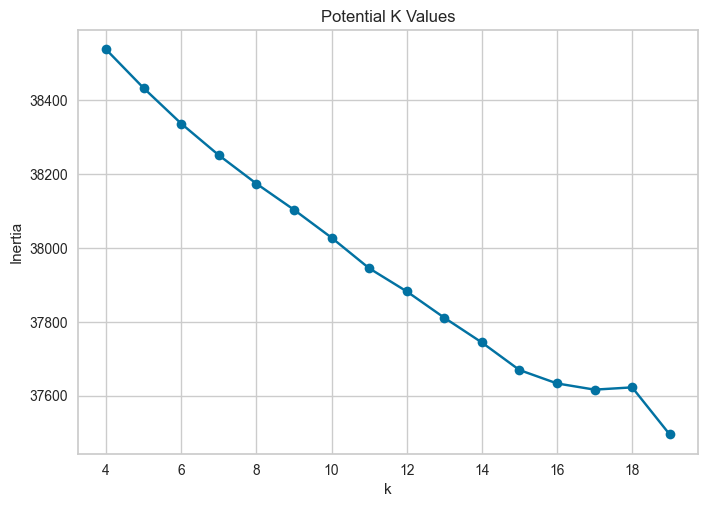

Here are the scores for each cluster starting with 4 and having a max of20 
 {4: 38537.88711148743, 5: 38433.22938148837, 6: 38337.10435205225, 7: 38251.5228599513, 8: 38174.53016772159, 9: 38103.80954951787, 10: 38028.09888244995, 11: 37945.35593535091, 12: 37882.65820341937, 13: 37811.380867091546, 14: 37744.28116729694, 15: 37669.71370433804, 16: 37633.36155054368, 17: 37616.55711506424, 18: 37622.68144281724, 19: 37495.12045750814}


In [31]:

potential_k=find_optimal_kV2(4,20,vec_encron_documents) # finding best k based off of Inerita
print("Here are the scores for each cluster starting with " +str(4)+ " and having a max of"+str(20),"\n", potential_k)


C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.

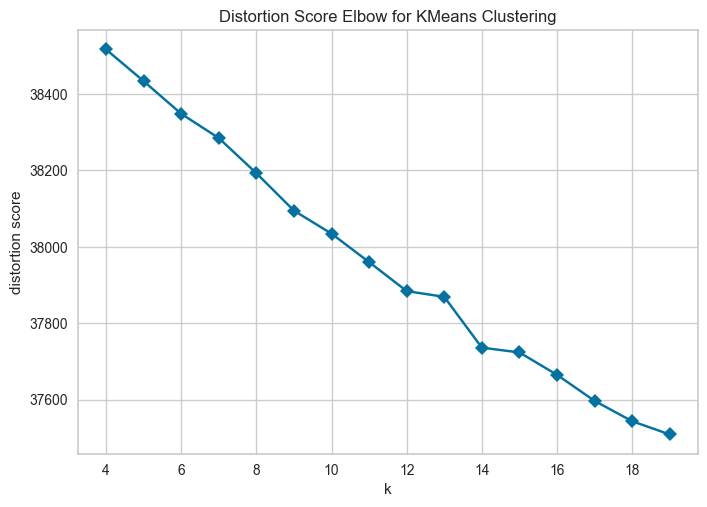

In [32]:
find_optimal_kV1(4,20,vec_encron_documents) # finding optimal k using package (Elbow Method)

In [71]:
elbow_method = [15,37637.291] # K, inertia
print(str(elbow_method[0])+ " is the suggest number of clusters using the elbow method.\nThe score was: "+str(elbow_method[1]),"\n\nI will be investigating when k = 3 and 15")

15 is the suggest number of clusters using the elbow method.
The score was: 37637.291 

I will be investigating when k = 4, 9 and 15


Let's start off with k = 15.


C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Inertia for model with15clusters is: 37669.71370433804


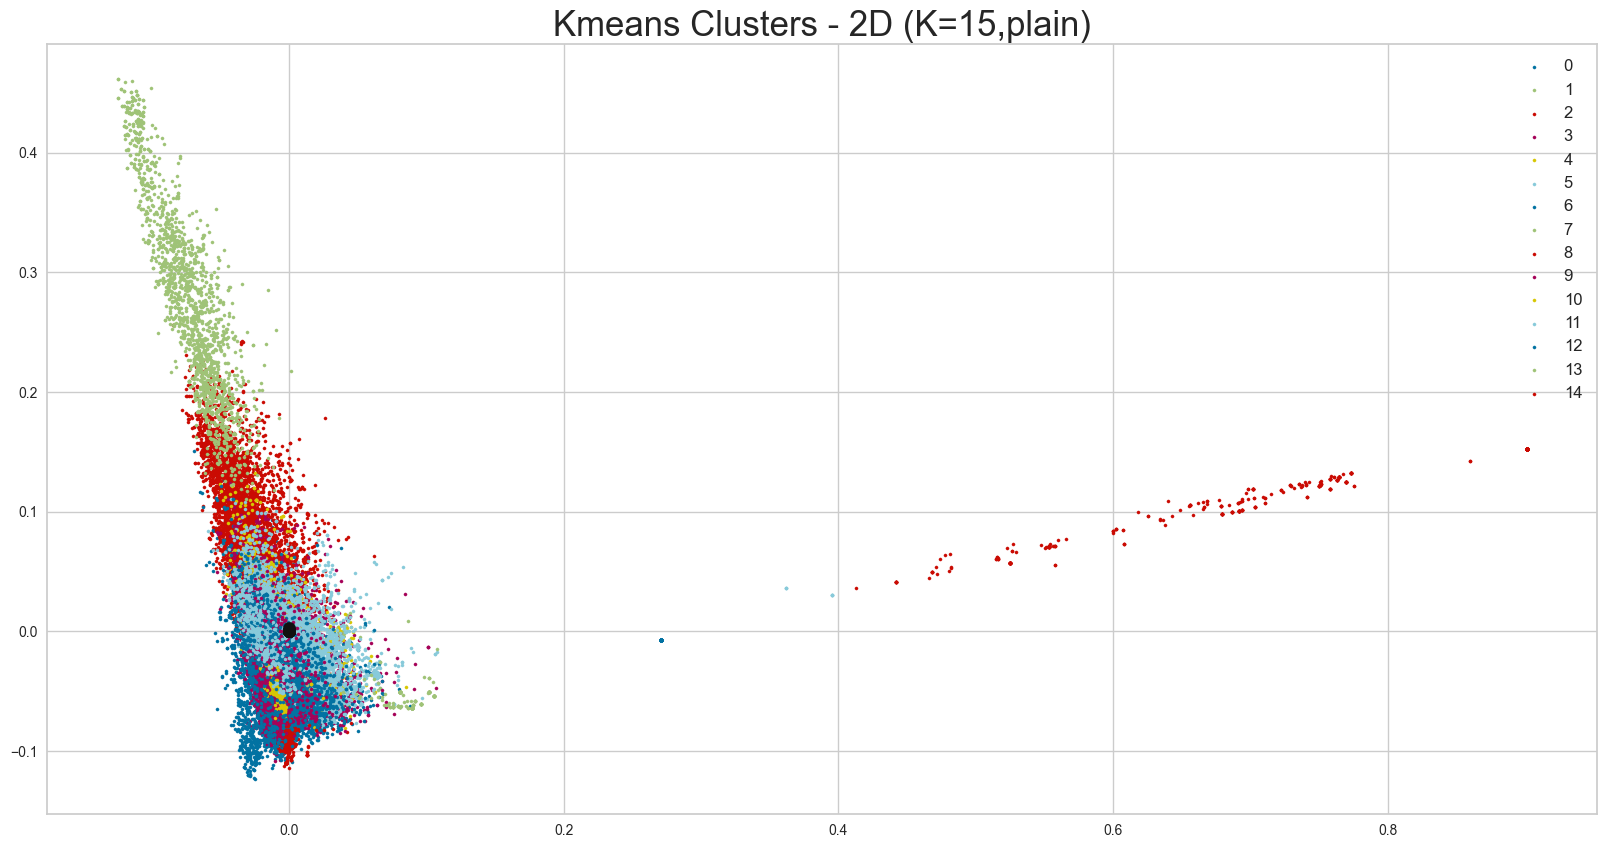

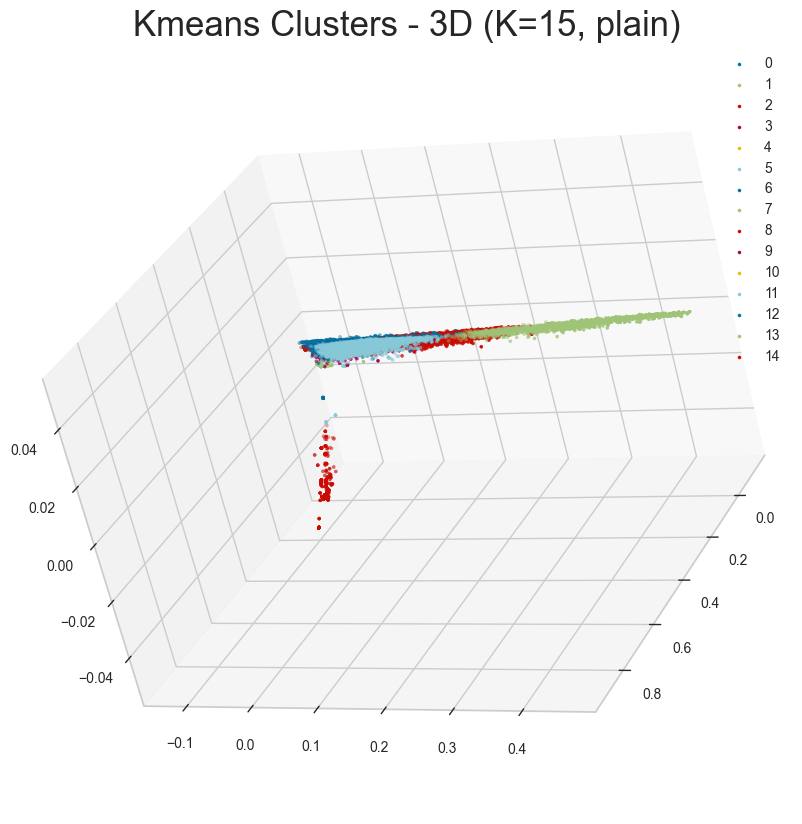

In [76]:
print("Let's start off with k = 15.")
k15 = kmeans(vec_encron_documents,elbow_method[0],pca,"plain")

TfidfVectorizer(stop_words={'english'})
Top 50 terms in each cluster (K=15,plain)
Cluster 0: meeting conference attend room scheduled thursday monday wednesday discuss number friday tuesday date code agenda tomorrow office schedule assistant location participant plan held forward jeff affair houston phone lynn follow group dial meet government place rick morning november october fax callin set administrative sally regarding mark issues cst afternoon team



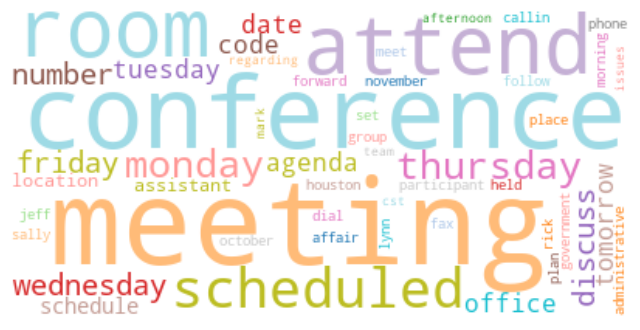

Cluster 1: reserving dayahead pjm nyiso realtime verify correct posting prices hour website beginning official found eca20001006b market copy address eca eca20010608b september august buses july hoursbeginning ecab pursuant proxy april external december october addition november ibrahim monitoring performance reserve isnt dam accuracy transfer reservation previously complete data follow problem price fiduciary



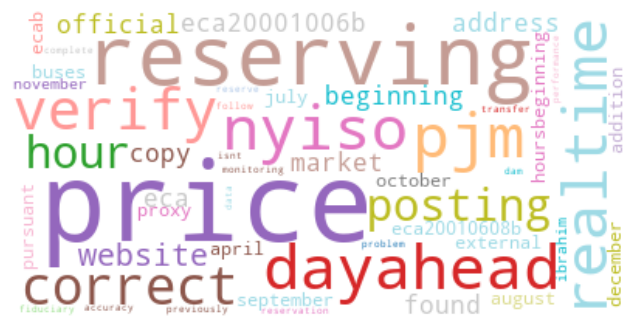

Cluster 2: market energy power business gas risk issues customer california management provide cost group price current issue order forward contract service company meeting services plan rate process point include based position discuss think support decision report term access including working trading discussion month commission result number part additional deal comment end



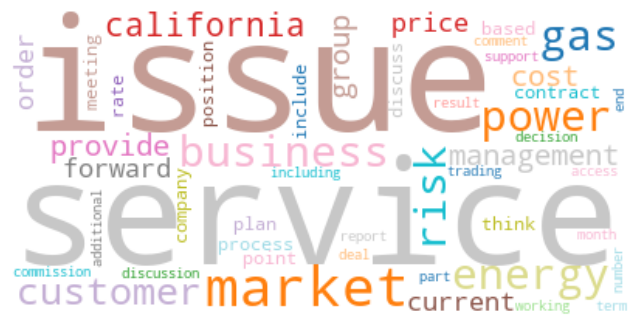

Cluster 3: attached comment file draft review document find copy forward letter version meeting list summary send final california report market jeff revised respond regarding energy look gas received note memo presentation tomorrow fax request spreadsheet discussed provide group discuss morning power proposal fyi issues proposed friday office help phone team feel



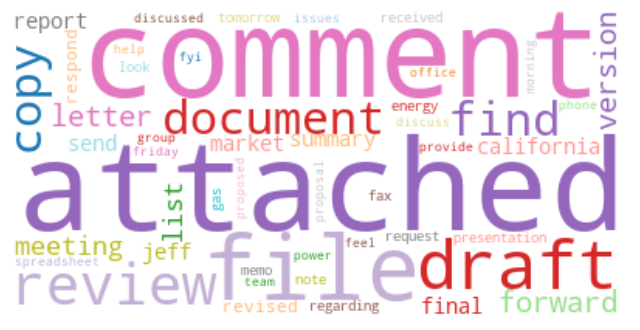

Cluster 4: click link receive online free unsubscribe offer web dear visit special service account customer site privacy list address message check save password send wish help access page order browser user gift internet product card mailing detail future reply remove receiving view find note youll member friend registered enter clicking subscription



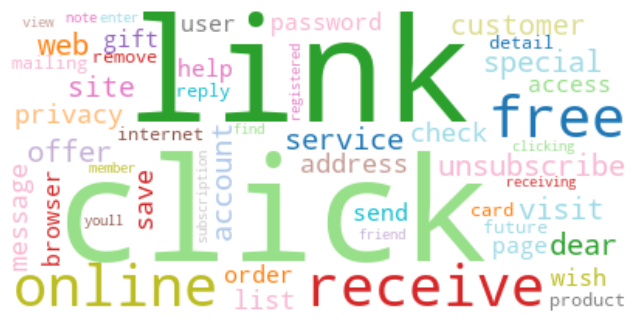

Cluster 5: gas office received help number power send group list business fax date team request report services deal think houston energy message desk note friday give phone review company lynn california market jeff regarding forward copy sure michelle fyi look working morning process trading contract monday due rick employees point problem



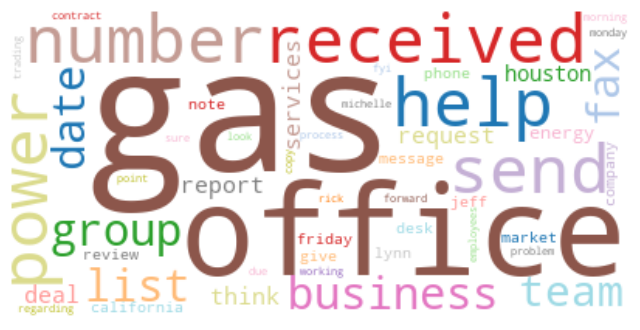

Cluster 6: going ill think hope thing guy night jeff weekend sorry hey love thought sure look talk try give youre phone dinner home fax tomorrow ive wanted didnt friday free send nice saturday tell getting forward soon morning fun friend sound happy cell help game hear coming msn tonight lot sunday



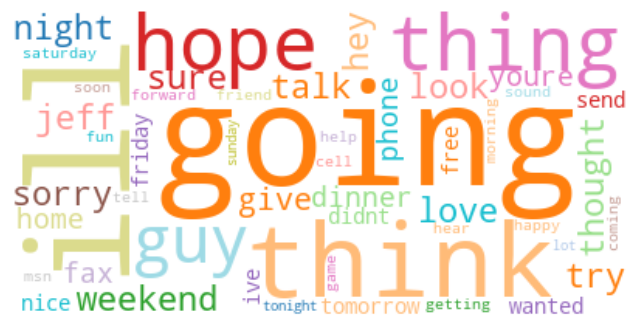

Cluster 7: resource type create click approval request application date pending approver backoffice act eol listed security received manager review directory admin permanent nahoutrdhoustonpwrcommonpower2region nahoutrdhoustonpwrcommonelectric read requester acceptance data local risk kobra unlisted form vpn product desktop stack approve econnect requestoriginal typegrant nameeol peoplefinder reject bridge mhc enter report monitor submit select



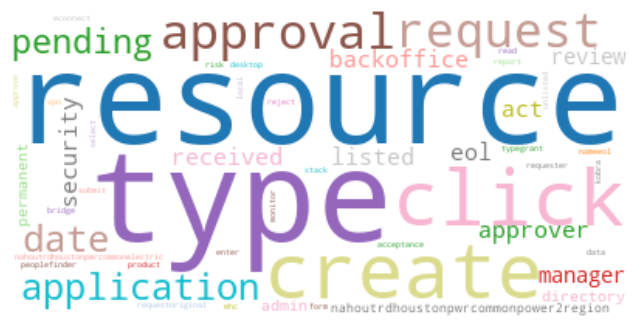

Cluster 8: description detailed central standard mtg team room eb4102 conference time230 time130 time1030 leader ava35842market time300 lynn ava35842 entryinvitation attendees eb4194 council office time900 time1100 repeat meeting sheila larry bergermonthly time1000 parent eb49c2 delete dates meet services time100 nacey acct manuel time830 blair time1130 tammy time400 customer roundtable account acctg monthly



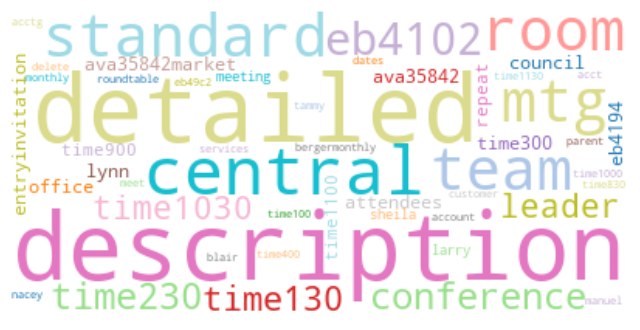

Cluster 9: america north corp houston smith street texas michelle privileges sally attached attorneyclient bailey susan phone protected product cash message suite andor ena meeting forward think agreement help regarding trading going company deal gas date group review provide business fax risk thought team look list friday office give send counterparty request



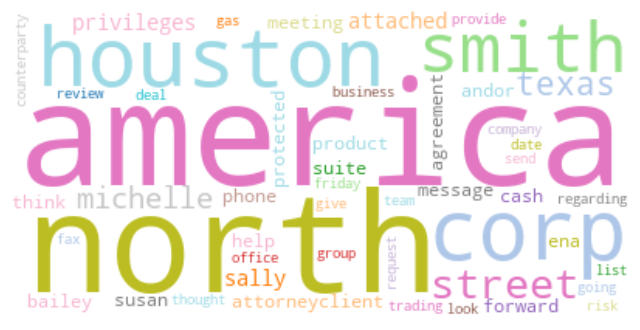

Cluster 10: expense employee changed status approval total amount due report approved paid payment automated administrator ready pending progress processed rosalee fleming lunch coronado preapproved wallace sera agc lunches marie sherri harrington club kerry derrick trip accounting dues dinner meal ting alma outing dong clerk meeting cellular steven review conference gorte forum



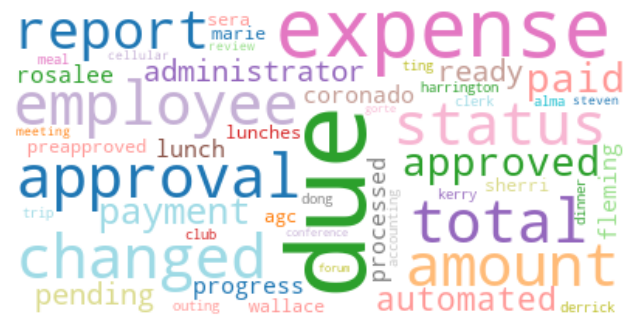

Cluster 11: game football season coach sunday play player injury yard games against team practice knee receiver fantasy true start longhorn sportslinecom defensive touchdown mack playing hes brown ereport played starting receiving starter quarterback offense orange horn ankle customize nfl defense johnson big passes offensive coaches recruiting injured reschedule league running ball



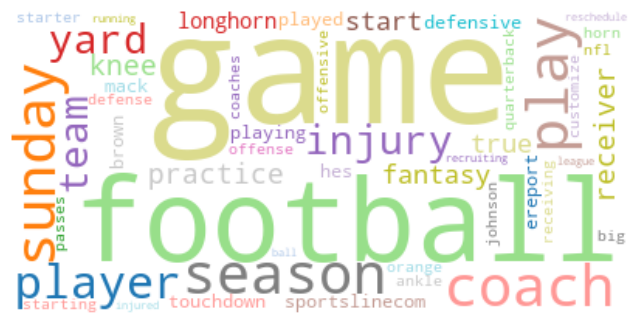

Cluster 12: estoppel enforceable binding relied acceptance affiliates sole affiliate relevant strictly property evidence prohibited material party andor copies create basis offer contract receive corp message review reply delete going october think jeff hey ill sure look friday night monday yes hope fax morning wrote thing sound tuesday guy send sorry houston



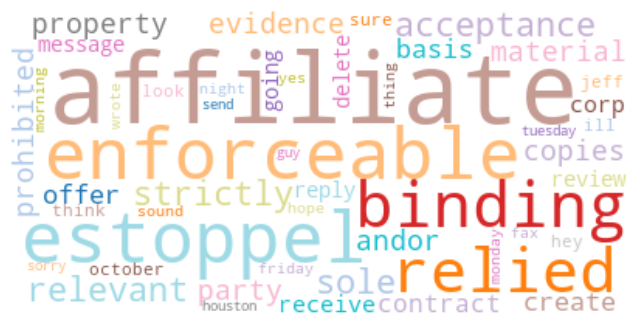

Cluster 13: power energy california electricity utilities gas prices market commission regulatory electric wholesale crisis davis federal plant states public price edison companies californias generator water contract utility supply president billion independent regulator consumer southern company rate longterm cost governor rates pacific customer transmission gray grid cap summer blackout system demand gov



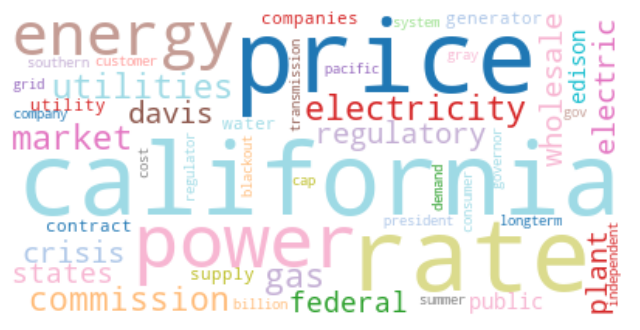

Cluster 14: schedulingiso oportlandwestdeskcalifornia parsing hourahead retrieving variances detected ancillary awarded messages log schedules continuing error date type trans final file id hour start data process price epmi sc ciso engy mkt preferred schedule ectrt interchg importexport tie found dever pverde rndmtn malin variance point energy wheel impexp tblintchg psuedo fcornr purch



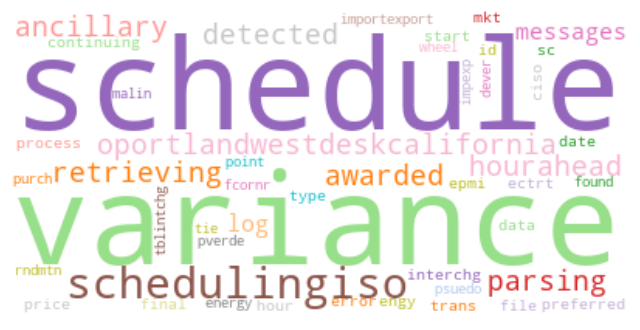

{0: ['meeting',
  'conference',
  'attend',
  'room',
  'scheduled',
  'thursday',
  'monday',
  'wednesday',
  'discuss',
  'number',
  'friday',
  'tuesday',
  'date',
  'code',
  'agenda',
  'tomorrow',
  'office',
  'schedule',
  'assistant',
  'location',
  'participant',
  'plan',
  'held',
  'forward',
  'jeff',
  'affair',
  'houston',
  'phone',
  'lynn',
  'follow',
  'group',
  'dial',
  'meet',
  'government',
  'place',
  'rick',
  'morning',
  'november',
  'october',
  'fax',
  'callin',
  'set',
  'administrative',
  'sally',
  'regarding',
  'mark',
  'issues',
  'cst',
  'afternoon',
  'team',
  'passcode',
  'december',
  'committee',
  'attending',
  'lunch',
  'hour',
  'note',
  'reminder',
  'california',
  'host',
  'energy',
  'dialin',
  'sue',
  'jim',
  'weekly',
  'dasovich',
  'detail',
  'update',
  'steve',
  'presentation',
  'january',
  'member',
  'start',
  'look',
  'management',
  'conflict',
  'joseph',
  'bob',
  'attached',
  'august',
  'able'

In [70]:
top_terms_in_cluster(k15,vectorizer,15,"plain")

In [16]:
print("K=3")
updated_encron_vocab = update_encron_vocab(encron_vocab)
documents_ps = build_document_ps(updated_encron_vocab)
vec_encron_documents_ps= vectorize_document(documents_ps,vectorizer)


K=3


C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.

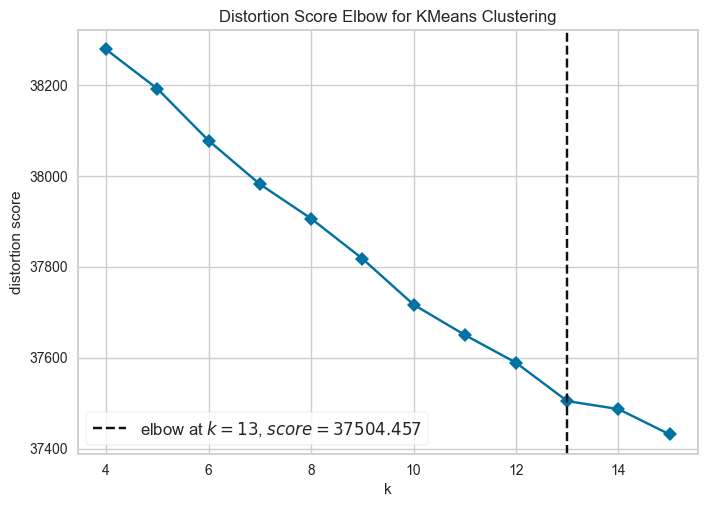

In [17]:
find_optimal_kV1(4,16,vec_encron_documents_ps) # finding optimal k using package (Elbow Method)

C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Inertia for model with 13 clusters is: 37539.73081239446


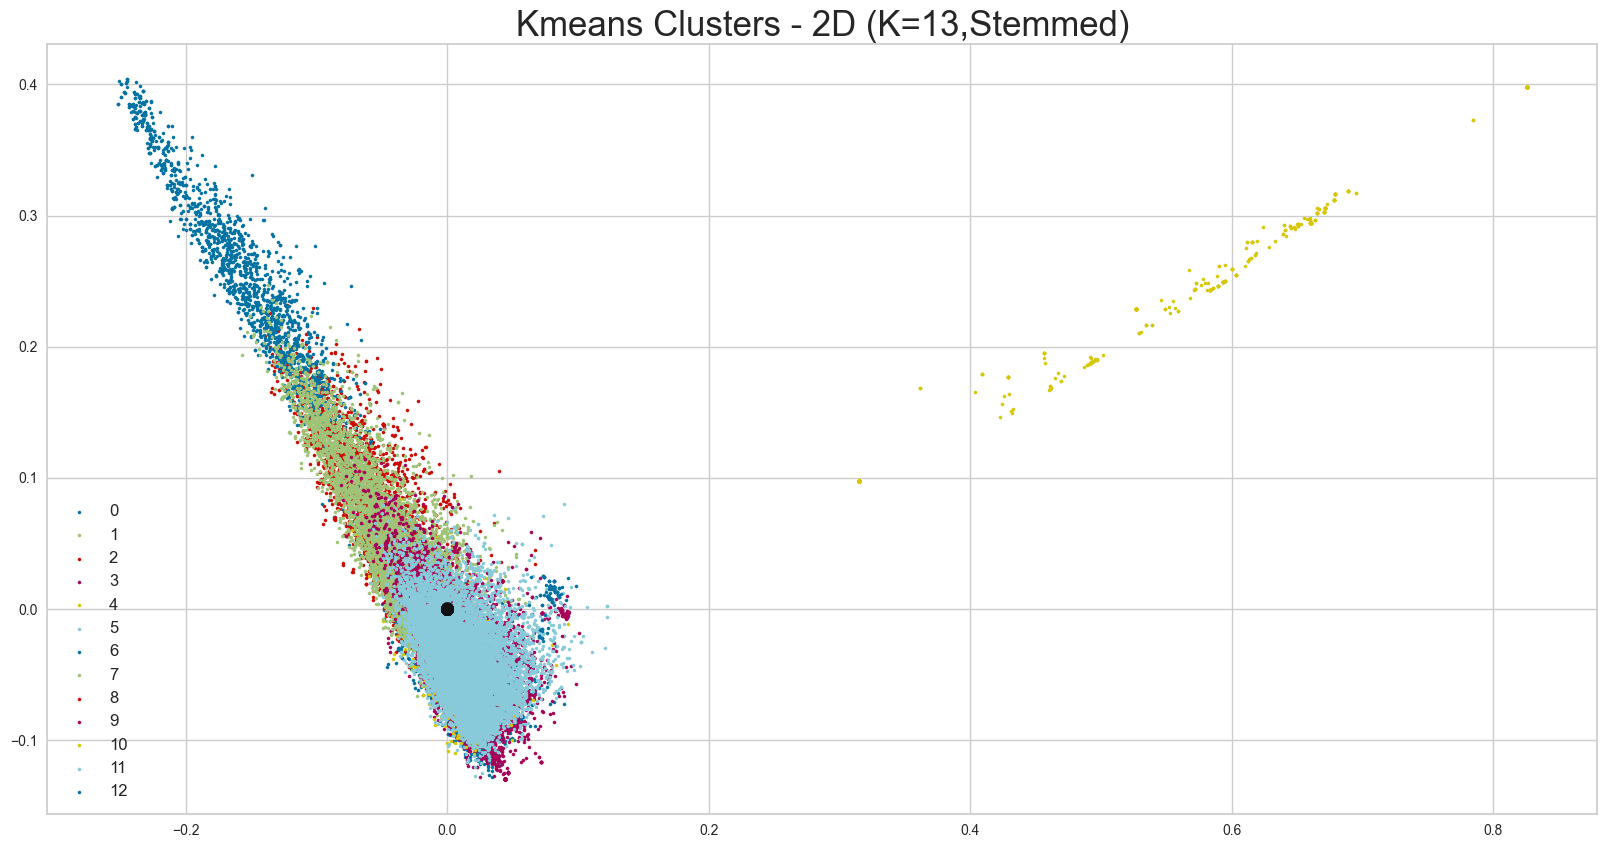

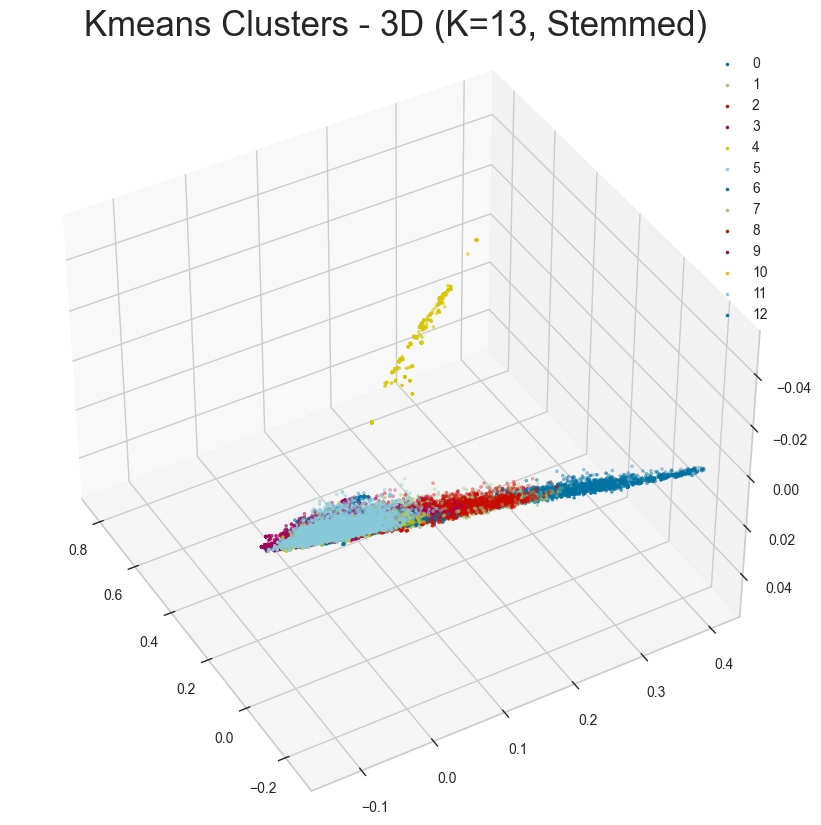

In [18]:
elbow_score_ps = [11,37546.953]
k11 = kmeans(vec_encron_documents_ps,13,pca,"Stemmed")

TfidfVectorizer(stop_words={'english'})
Top 50 terms in each cluster (K=13,Stemmed)
Cluster 0: go think hope ill thing night love weekend look guy game talk tri hey sure sunday sorri saturday thought home play start give tell dinner



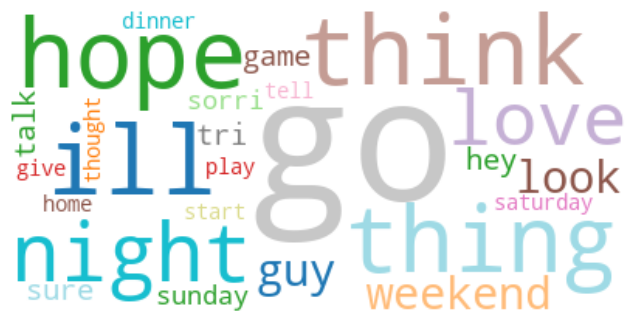

Cluster 1: estoppel bind enforc reli strictli relev affili sole evid properti prohibit materi andor accept basi parti creat corp contract offer messag review copi repli receiv



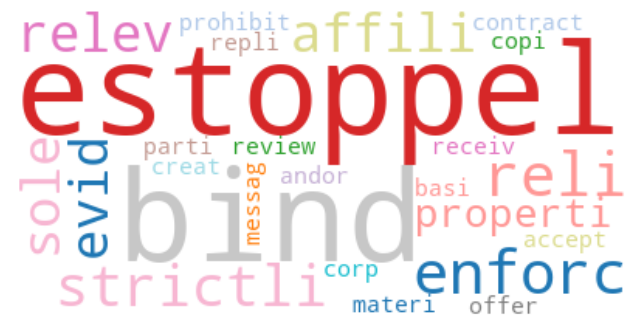

Cluster 2: california util market rate issu propos jeff commiss cpuc energi power custom file price pge gener discuss ferc direct cost contract bill dasovich order comment



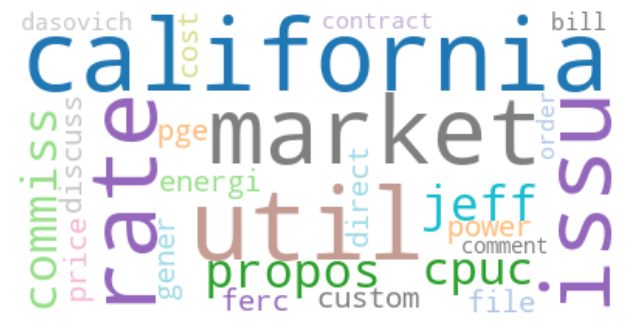

Cluster 3: meet room conference attend schedul central team descript detail confer standard mtg number code thursday particip date wednesday tuesday monday discuss friday locat dial forward



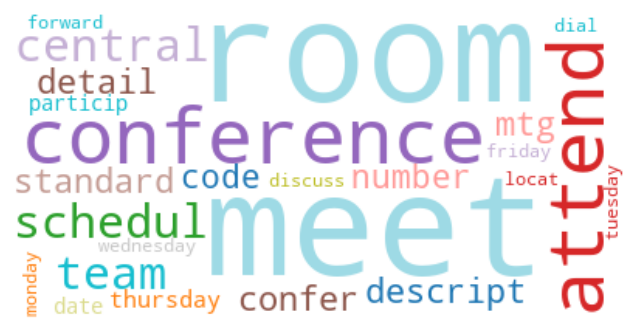

Cluster 4: america north corp houston smith street texa michel attach salli attorneycli bailey privileg susan product phone meet cash date forward messag andor ena suit protect



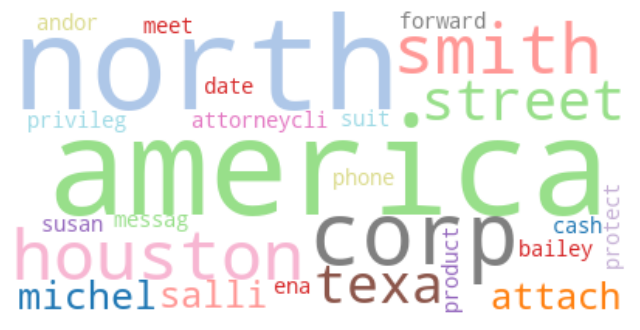

Cluster 5: attach comment copi review draft document find discuss send meet receiv list forward version regard letter revis summari final request note provid report look includ



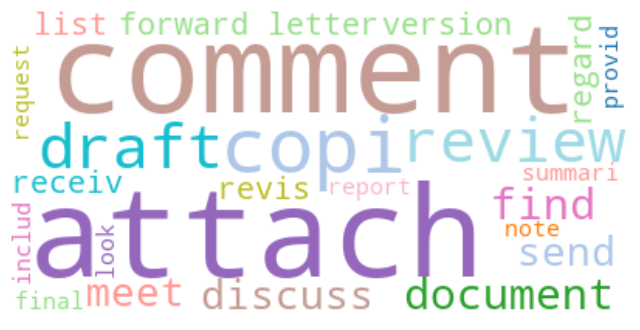

Cluster 6: power california electr energy market commiss energi util pow crisi davi pric ga compani price public gener electricity edison wholesale state suppli regul rate contract



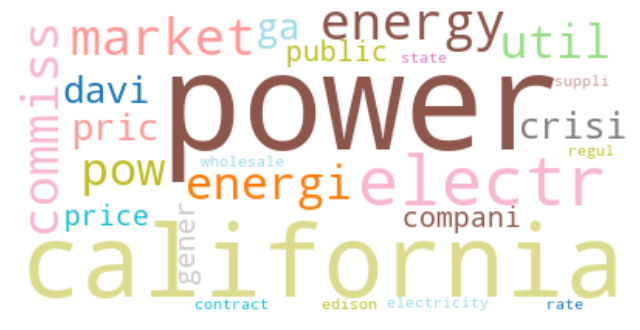

Cluster 7: manag busi market provid risk discuss compani includ issu group develop servic process report trade oper meet requir addit plan help respons review complet continu



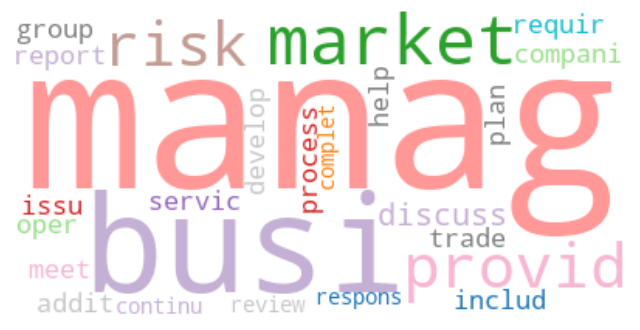

Cluster 8: expens statu amount total employe approv due chang report paid payment autom readi administr pend lunch progress rosale coronado fleme wallac preapprov sera agc harrington



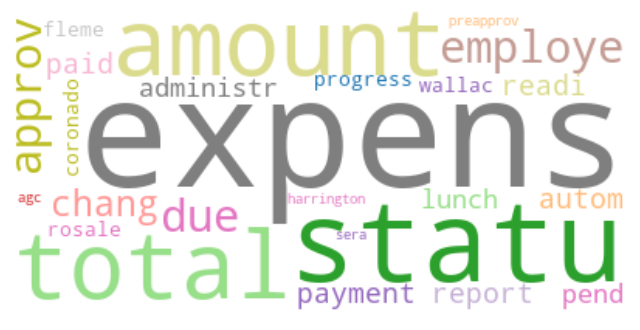

Cluster 9: click receiv link onlin list unsubscrib type free dear web offer servic visit special date request messag site applic address save account privaci mail send



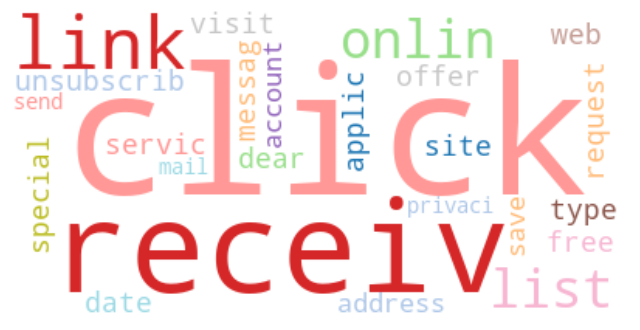

Cluster 10: hourahead schedulingiso oportlandwestdeskcalifornia pars varianc detect ancillari retriev log hour award error start schedul trans date typ id final data messag process continu price epmi



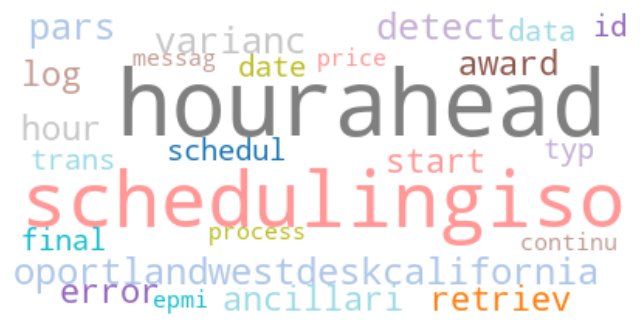

Cluster 11: offic meet ga help send number look think receiv fax list jeff date discuss ask schedul servic phone give request friday forward regard check monday



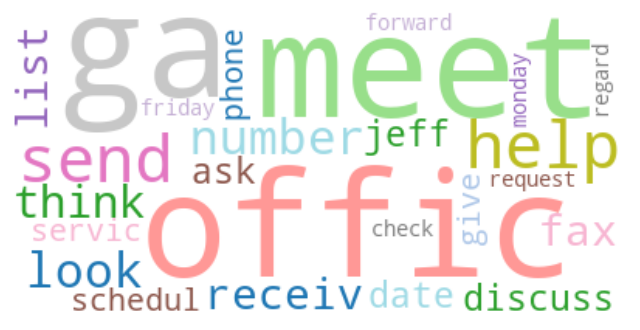

Cluster 12: dayahead pjm nyiso realtim verifi reserv correct hour websit offici found post price begin market copi address eca august septemb buse juli hoursbegin ecab pursuant



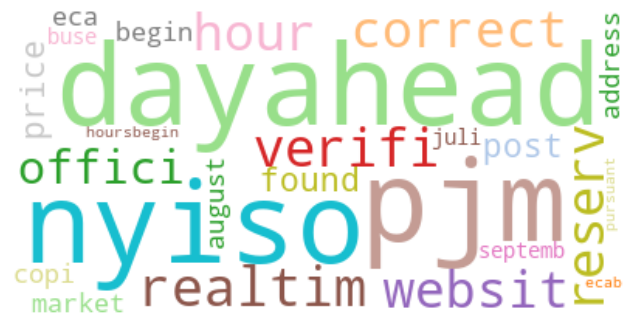

In [20]:
top_11 =top_terms_in_cluster(k11,vectorizer,13,"Stemmed")

In [21]:
vocab_top_11 = list(top_11.values())
vb_top_11= []
for i in vocab_top_11:
    vb_top_11+=i

top_11_dict = {}
for i in vb_top_11:
    if i in top_11_dict:top_11_dict[i]+=1
    else: top_11_dict[i]=1
